#Для визуализации карты

In [1]:
!pip install folium matplotlib mapclassify

#Импорт

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

#Валидация

In [3]:
buildings = gpd.read_file('/content/Building_input.geojson')

Посмотрим информацию о данных.
Итак, у нас есть следующие столбцы:


*   ID-здания
*   Статус (жилое/нежилое)
*   Номер здания
*   Тип здания
*   Этажность
*   Жилая площадь
*   Нежилая площадь
*   Общая площадь
*   Количество человек, проживающих в доме (для жилой застройки)
*   Геометрия














In [4]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47942 entries, 0 to 47941
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    47942 non-null  object  
 1   is_living             47942 non-null  float64 
 2   addr:housenumber      18775 non-null  object  
 3   building              47942 non-null  object  
 4   building:levels       47942 non-null  object  
 5   area_residential      47910 non-null  float64 
 6   area_non_residential  47676 non-null  float64 
 7   area                  47942 non-null  float64 
 8   people                47913 non-null  float64 
 9   area_total            47942 non-null  float64 
 10  geometry              47942 non-null  geometry
dtypes: float64(6), geometry(1), object(4)
memory usage: 4.0+ MB


Проблемы во входных данных

In [5]:
filtered_buildings = buildings[(buildings['building'] == 'school') & (buildings['people'] != 0)]
filtered_buildings

,id,is_living,addr:housenumber,building,building:levels,area_residential,area_non_residential,area,people,area_total,geometry
29349,13719,0.0,None,school,2,0.0,0.0,2964.0,490.0,2964.0,"POLYGON ((60.66048 56.78421, 60.66136 56.78384..."


In [6]:
buildings.loc[(buildings['building'] == 'school') & (buildings['people'] != 0), 'people'] = 0

Проверим уникальность id

In [7]:
is_id_unique = not buildings['id'].duplicated().any()

if is_id_unique:
    print("Столбец 'id' уникален.")
else:
    print("В столбце 'id' есть дубликаты.")

Столбец 'id' уникален.


In [8]:
buildings['is_living'].unique()

array([0., 1.])

Присваиваем столбцу, определяющему жилую застройку, формат bool

In [9]:
buildings['is_living'] = buildings['is_living'].astype(bool)

Удаляем ненужные столбцы. Для дальнейшего анализа оставим:
ID-здания, Статус (жилое/нежилое), Тип здания, Этажность, Жилая площадь, Общая площадь, Количество человек, Геометрия

In [10]:
columns_to_drop = ['addr:housenumber', 'area_non_residential', 'area']
buildings = buildings.drop(columns=columns_to_drop, errors='ignore')

Проверка пропущенных значений

In [11]:
buildings.isnull().sum()

id                   0
is_living            0
building             0
building:levels      0
area_residential    32
people              29
area_total           0
geometry             0
dtype: int64

Проверка этажности на строки


In [12]:
non_numeric_rows = buildings['building:levels'].apply(pd.to_numeric, errors='coerce').isna()
print(buildings.loc[non_numeric_rows, 'building:levels'])

5853    1;2
5854    1;2
Name: building:levels, dtype: object


Оставляем лишь первое число в строке

In [13]:
buildings['building:levels'] = buildings['building:levels'].str.extract('(\d+)', expand=False)

Восстанавливаем численность проживающих людей с помощтю модели регрессии. Для обучения модели и заполнения пропущенных значений, будем использовать столбцы 'area_total', 'building:levels', 'is_living'.

In [14]:
features = ['is_living', 'building:levels', 'area_total']

data_with_nan = buildings[buildings['people'].isnull()]
data_without_nan = buildings.dropna(subset=['people'])

X_train, X_test, y_train, y_test = train_test_split(
    data_without_nan[features], data_without_nan['people'], test_size=0.2, random_state=100
)

model = RandomForestRegressor(random_state=100)
model.fit(X_train, y_train)

predicted_people = model.predict(data_with_nan[features])

buildings.loc[buildings['people'].isnull(), 'people'] = predicted_people

Проверяем пропущенные значения

In [15]:
print(buildings['people'].isnull().sum())

0


Восстанавливаем жилую площадь с помощью модели регрессии. Для обучения модели и заполнения пропущенных значений, будем использовать столбцы 'area_total', 'building:levels', 'is_living'.

In [16]:
features = ['is_living', 'building:levels', 'area_total']

data_with_nan = buildings[buildings['area_residential'].isnull()]
data_without_nan = buildings.dropna(subset=['area_residential'])

X_train, X_test, y_train, y_test = train_test_split(
    data_without_nan[features], data_without_nan['area_residential'], test_size=0.2, random_state=100
)

model = RandomForestRegressor(random_state=100)
model.fit(X_train, y_train)

predicted_area_residential = model.predict(data_with_nan[features])

buildings.loc[buildings['area_residential'].isnull(), 'area_residential'] = predicted_area_residential

In [17]:
print(buildings['area_residential'].isnull().sum())

0


Моделька отработала корректно

In [19]:
examination = buildings[(buildings['is_living'] == 'False') & (buildings['people'] != 0)]
examination

,id,is_living,building,building:levels,area_residential,people,area_total,geometry


Унифицируем типы переменных

In [20]:
buildings['building:levels'] = buildings['building:levels'].astype(int)
buildings['people'] = buildings['people'].astype(int)
buildings['area_total'] = buildings['area_total'].astype(int)
buildings['area_residential'] = buildings['area_residential'].astype(int)

In [21]:
print(buildings.dtypes)

id                    object
is_living               bool
building              object
building:levels        int64
area_residential       int64
people                 int64
area_total             int64
geometry            geometry
dtype: object


Проверим распределение признаков жилой и нежилой застройке: как видно из графика количество зданий обоих типов примерно одинаковое

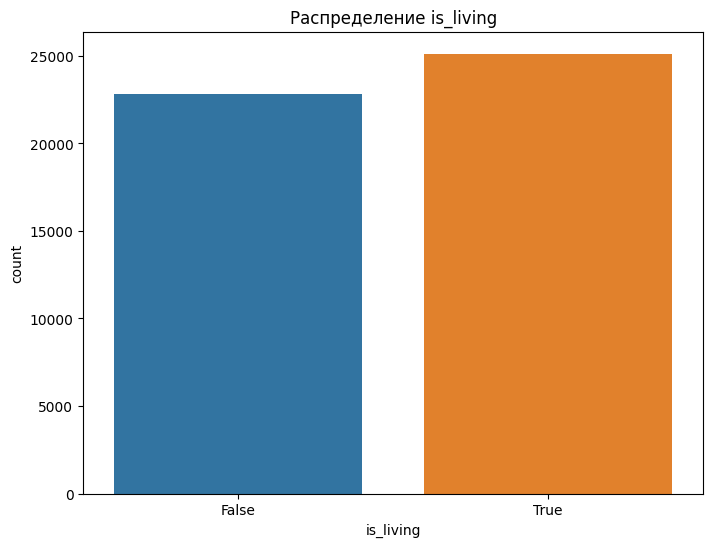

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_living', data=buildings)
plt.title('Распределение is_living')
plt.show()

Посмотрим на сервисы

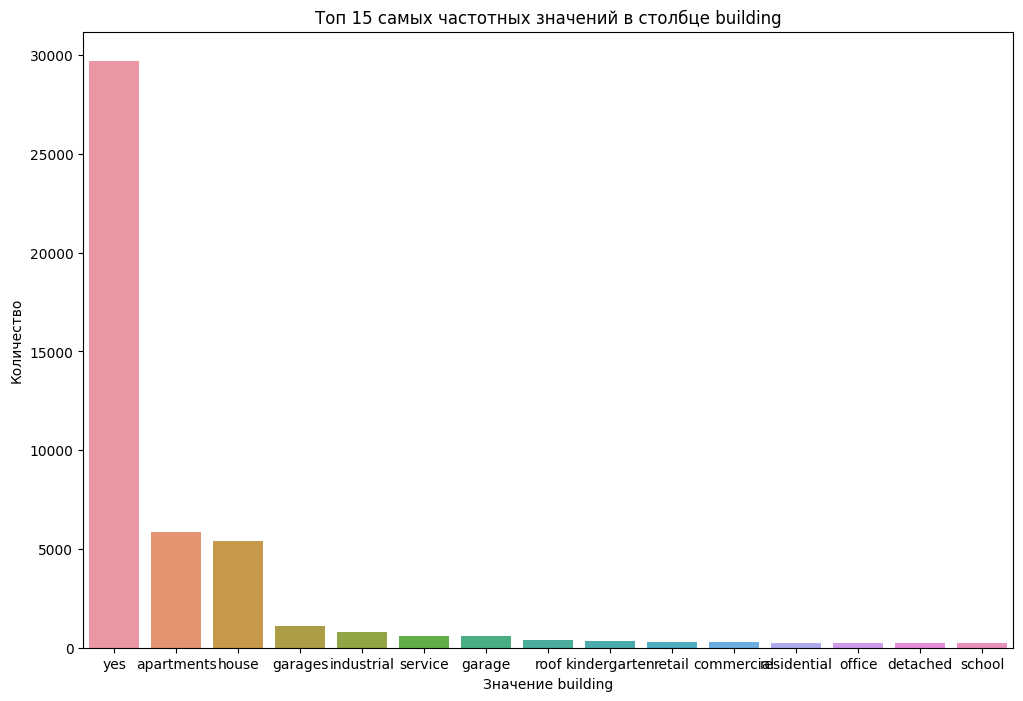

In [23]:
top_buildings = buildings['building'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_buildings.index, y=top_buildings.values)
plt.title('Топ 15 самых частотных значений в столбце building')
plt.xlabel('Значение building')
plt.ylabel('Количество')
plt.show()

In [24]:
top_buildings = buildings['building'].value_counts().head(15)

print("Топ 15 самых частотных значений в столбце 'building':")
print(top_buildings)

Топ 15 самых частотных значений в столбце 'building':
yes             29694
apartments       5881
house            5392
garages          1100
industrial        810
service           611
garage            593
roof              380
kindergarten      338
retail            303
commercial        283
residential       262
office            261
detached          258
school            218
Name: building, dtype: int64


Посмотрим, какую площадь занимают детские сады, а какую школы

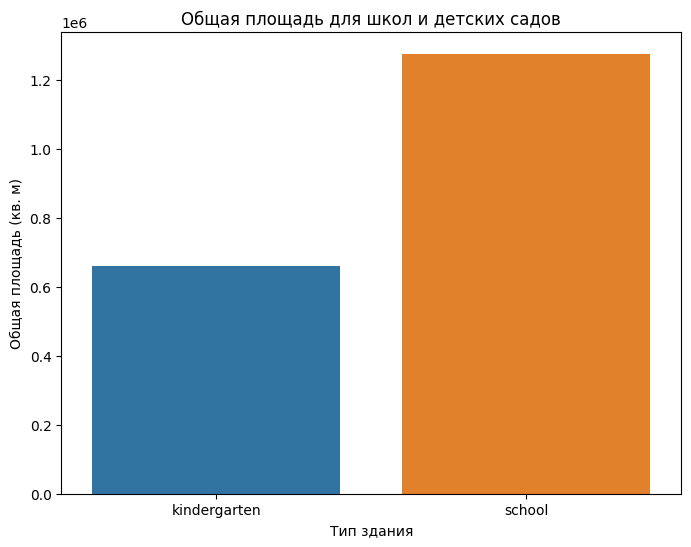

In [25]:
schools_and_kindergartens = buildings[buildings['building'].isin(['school', 'kindergarten'])]

total_area_by_building = schools_and_kindergartens.groupby('building')['area_total'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='building', y='area_total', data=total_area_by_building)
plt.title('Общая площадь для школ и детских садов')
plt.xlabel('Тип здания')
plt.ylabel('Общая площадь (кв. м)')
plt.show()

Посморим, как распределяются школы по площади

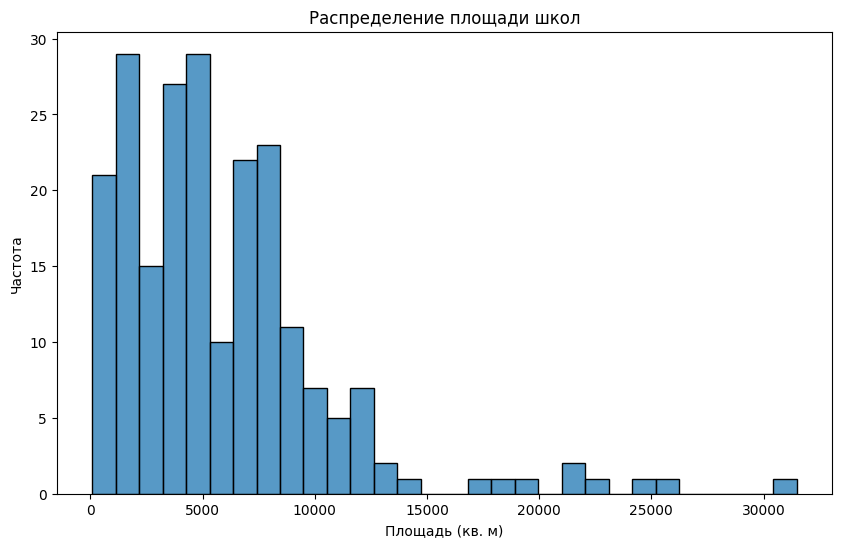

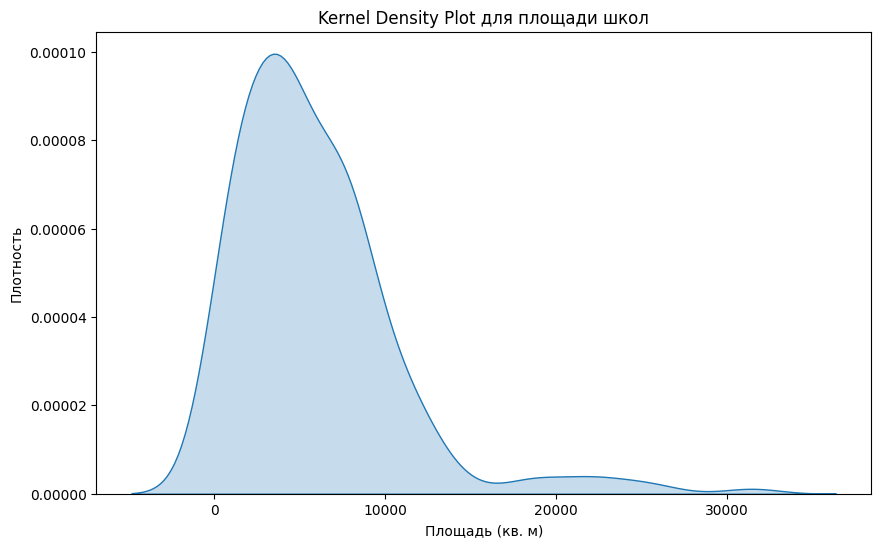

In [26]:
schools_data = buildings[buildings['building'] == 'school']

plt.figure(figsize=(10, 6))
sns.histplot(schools_data['area_total'], bins=30, kde=False)
plt.title('Распределение площади школ')
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(schools_data['area_total'], fill=True)
plt.title('Kernel Density Plot для площади школ')
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Плотность')
plt.show()

Посмотрим на распределение этажности

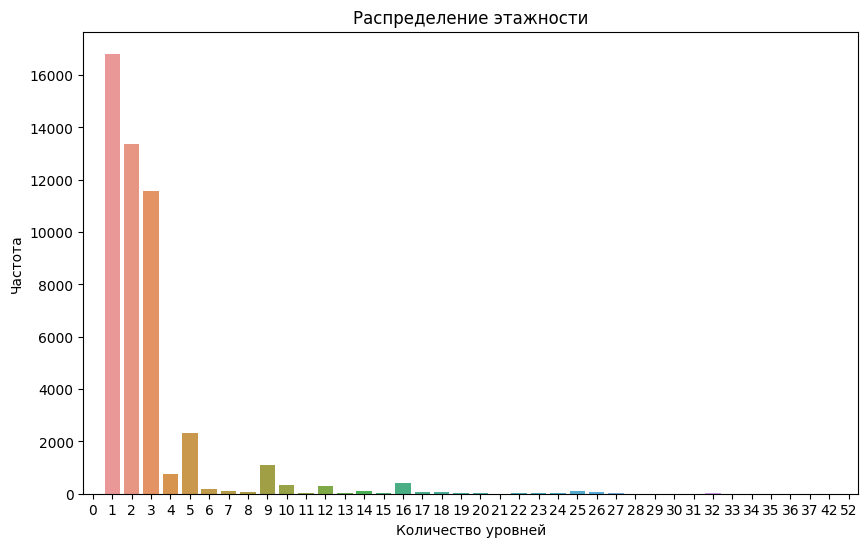

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x='building:levels', data=buildings)
plt.title('Распределение этажности')
plt.xlabel('Количество уровней')
plt.ylabel('Частота')
plt.show()

In [28]:
map_explore = buildings.explore(cmap='cool', column='is_living')
map_explore.save("map_explore.html")

In [30]:
buildings.to_file('Buildings_output.geojson', driver='GeoJSON')